In [1]:
import pandas as pd
import numpy as np
import os
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter


In [2]:

# Load arrays from the saved .npy files
time = np.load("/Users/adaciortan/Desktop/experiment data/daca ai fii un stick/the column/2025-07-01_h2-100bar_SRB-time.npy")
volume_1 = np.load("/Users/adaciortan/Desktop/experiment data/daca ai fii un stick/the column/2025-07-01_h2-100bar_SRB-volume_1.npy")
volume_2 = np.load("/Users/adaciortan/Desktop/experiment data/daca ai fii un stick/the column/2025-07-01_h2-100bar_SRB-volume_2.npy")




In [98]:

def auto_stitch(array1, array2):
    # Convert to numpy arrays to handle the math
    a1 = np.array(array1)
    a2 = np.array(array2)
    
    # 1. Get the connection points
    last_val_a1 = a1[-1]
    first_val_a2 = a2[0]
    
    # 2. Calculate the gap (offset)
    offset = last_val_a1 - first_val_a2
    
    # 3. Shift the second array and join
    a2_shifted = a2 + offset
    
    return np.concatenate([a1, a2_shifted])

# Usage:
result_1 = auto_stitch(volume_1, v1B)
result_2 = auto_stitch(volume_2, v2B)

In [116]:
# data log was broken, made new time array
prov_cum_min = np.multiply(np.arange(0, 18324),1/1440)
time_days=prov_cum_min


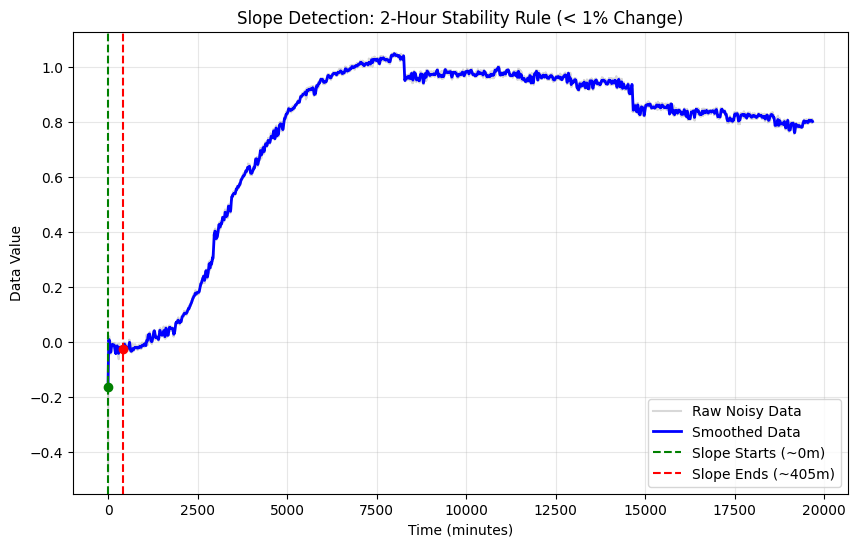

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

def detect_slope_bounds(time, data, window_mins=120, threshold=0.01):
    """
    Identifies the start and end of a slope in noisy data.
    
    Parameters:
    - time: Array of time values in minutes.
    - data: Array of noisy data values.
    - window_mins: The span to check for stability (default 120 mins).
    - threshold: Relative change in slope (0.01 = 1%).
    """
    
    # 1. Smooth the data to handle noise (Savitzky-Golay filter)
    # Window length must be odd; 51 is a good starting point for 1min intervals
    smoothed = savgol_filter(data, window_length=51, polyorder=3)
    
    # 2. Calculate the slope (dy/dt)
    slopes = np.gradient(smoothed, time)
    
    start_idx = None
    end_idx = None
    
    # 3. Find Start: first point where slope is significantly non-zero
    # (Defined here as 10% of the maximum observed slope)
    max_slope = np.max(np.abs(slopes))
    start_threshold = max_slope * 0.1
    for i in range(len(slopes)):
        if abs(slopes[i]) > start_threshold:
            start_idx = i
            break
            
    # 4. Find End: 2-hour window where the average change in slope is < 1%
    # We iterate from the start point onwards
    if start_idx is not None:
        for i in range(start_idx, len(slopes) - window_mins):
            # Get the slope at the start and end of the 2-hour window
            m_now = slopes[i]
            m_future = slopes[i + window_mins]
            
            # Calculate relative change
            if abs(m_now) > 1e-6:
                rel_change = abs((m_future - m_now) / m_now)
            else:
                rel_change = 0 # If slope is effectively zero, it has ended
            
            # Check if change is less than 1% (0.01)
            # We look for this after the slope has passed its peak
            if rel_change < threshold and i > np.argmax(np.abs(slopes)):
                end_idx = i
                break
                
    return start_idx, end_idx, smoothed

# --- Example Usage & Plotting ---

y_noisy=volume_1-volume_2
start, end, y_smooth = detect_slope_bounds(time, y_noisy)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(time, y_noisy, label='Raw Noisy Data', color='gray', alpha=0.3)
plt.plot(time, y_smooth, label='Smoothed Data', color='blue', linewidth=2)

if start is not None:
    plt.axvline(time[start], color='green', linestyle='--', label=f'Slope Starts (~{t[start]}m)')
    plt.scatter(t[start], y_smooth[start], color='green', zorder=5)

if end is not None:
    plt.axvline(time[end], color='red', linestyle='--', label=f'Slope Ends (~{t[end]}m)')
    plt.scatter(time[end], y_smooth[end], color='red', zorder=5)

plt.title("Slope Detection: 2-Hour Stability Rule (< 1% Change)")
plt.xlabel("Time (minutes)")
plt.ylabel("Data Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [166]:
import numpy as np

def daily_volume_rate(a: np.ndarray, b: np.ndarray):
    """
    Calculate daily volume change rates from volume (a) and time in days (b).

    Parameters
    ----------
    a : np.ndarray
        Array of volume values.
    b : np.ndarray
        Array of time values (days), same length as a.

    Returns
    -------
    rates : np.ndarray
        Array of daily rates (Δvolume / Δtime per day).
        If a day has only one point, the rate is NaN.
    """

    if len(a) != len(b):
        raise ValueError("Arrays a and b must have the same length")

    if len(a) == 0:
        return np.array([])

    # Floor times to group into days
    day_bins = np.floor(b).astype(int)
    unique_days = np.unique(day_bins)

    rates = []

    for day in unique_days:
        mask = day_bins == day
        a_day = a[mask]
        b_day = b[mask]

        if len(a_day) == 1:
            # Only one point → cannot compute slope
            rates.append(np.nan)
        else:
            # Linear fit (slope = rate of change per day)
            slope, _ = np.polyfit(b_day, a_day, 1)
            rates.append(slope)

    return np.array(rates)


In [167]:
# Example data
rates_1 = daily_volume_rate(moles_consumed, time_days_trimmed)
#rates_2 = daily_volume_rate(th_c_vol2_3, th_cum_min_2)
print("Rates per day:", rates_1)


Rates per day: [ 0.00950644  0.17432904  0.92594138  0.96769943  0.59083977  0.32159139
  0.13895674  0.02197999  0.04434821 -0.02181731  0.02117665  0.02689818
 -0.10935512]


In [169]:
d=4.5 #diameter in cm
A=3.14*(d/2)**2
print(A)
rate_per_area= np.multiply(rates_1, 1/A)
print(rate_per_area)


15.89625
[ 0.00059803  0.01096668  0.05824904  0.06087596  0.0371685   0.02023064
  0.00874148  0.00138272  0.00278985 -0.00137248  0.00133218  0.00169211
 -0.0068793 ]


In [170]:
def calculate_slope(time, values, start_day, end_day):
    """
    Calculates the slope (linear regression) of 'values' vs 'time'
    within the specific time range [start_day, end_day].
    """
    # Filter data in range
    mask = (time >= start_day) & (time <= end_day)
    t_subset = time[mask]
    v_subset = values[mask]
    
    if len(t_subset) < 2:
        return None, "Insufficient data points (need at least 2)"
        
    # Fit linear regression (degree 1: y = mx + c)
    coeffs = np.polyfit(t_subset, v_subset, 1)
    slope = float(coeffs[0])     # 👈 Convert to normal Python float
    
    return slope



In [171]:
slope=calculate_slope(time_days_trimmed, moles_consumed, 2, 3.5)

print (slope)


0.9923268504858987


In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def process_experiment_data(x, y, window=120, threshold_pct=0.5):
    """
    Finds the start and end points of a slope between two plateaus.
    
    Criteria: A region is a plateau if the volume change over 'window' 
    minutes is less than 'threshold_pct' of the total volume range.
    
    Parameters:
    - x: np.array of time (e.g., minutes)
    - y: np.array of volume readings
    - window: The stability window in minutes (default 120)
    - threshold_pct: The % change threshold (default 0.01 for 1%)
    """
    # 1. Calculate the total range of the volume to define the 1% threshold
    vol_range = np.max(y) - np.min(y)
    threshold = vol_range * threshold_pct
    
    # 2. Use a rolling window to find the absolute change over time
    # We look forward: 'is there a change of >1% in the NEXT 120 minutes?'
    y_series = pd.Series(y)
    delta_y = (y_series.shift(-window) - y_series).abs()
    
    # 3. Identify indices where the change exceeds the threshold
    significant_indices = np.where(delta_y > threshold)[0]
    
    if len(significant_indices) == 0:
        print("No slope detected based on the given threshold.")
        return None, None

    # The start is the first index where change begins
    start_idx = significant_indices[0]
    
    # The end is where the 120-minute window finally stops seeing the slope
    # We add the window size to align it with the actual 'knee' of the curve
    end_idx = min(significant_indices[-1] + window, len(y) - 1)
    
    # --- Visualization Part ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    # Plot 1: Initial Data and Detection
    ax1.plot(x, y, color='silver', label='Initial Data (Noisy)', alpha=0.8)
    ax1.plot(x[start_idx:end_idx], y[start_idx:end_idx], color='blue', linewidth=2, label='Detected Slope')
    ax1.axvline(x[start_idx], color='green', linestyle='--', label=f'Start: {x[start_idx]} min')
    ax1.axvline(x[end_idx], color='red', linestyle='--', label=f'End: {x[end_idx]} min')
    ax1.set_ylabel('Volume')
    ax1.set_title('Experiment Data: Slope Delimitation')
    ax1.legend()
    
    # Plot 2: The Logic (Rate of Change)
    ax2.plot(x, delta_y, color='purple', label=f'Change over {window} min')
    ax2.axhline(threshold, color='orange', linestyle=':', label='1% Threshold')
    ax2.set_ylabel('$\Delta$ Volume')
    ax2.set_xlabel('Time (min)')
    ax2.set_title('Detection Metric (Rolling Stability)')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    return start_idx, end_idx

# Example usage:
start, end = process_experiment_data(moles_consumed,time)
# total_consumed = y[end] - y[start]

No slope detected based on the given threshold.


<>:56: SyntaxWarning: invalid escape sequence '\D'
<>:56: SyntaxWarning: invalid escape sequence '\D'
/var/folders/5z/hkz232rd2_n78cjbyj1g9t_40000gn/T/ipykernel_79192/2204059005.py:56: SyntaxWarning: invalid escape sequence '\D'
  ax2.set_ylabel('$\Delta$ Volume')


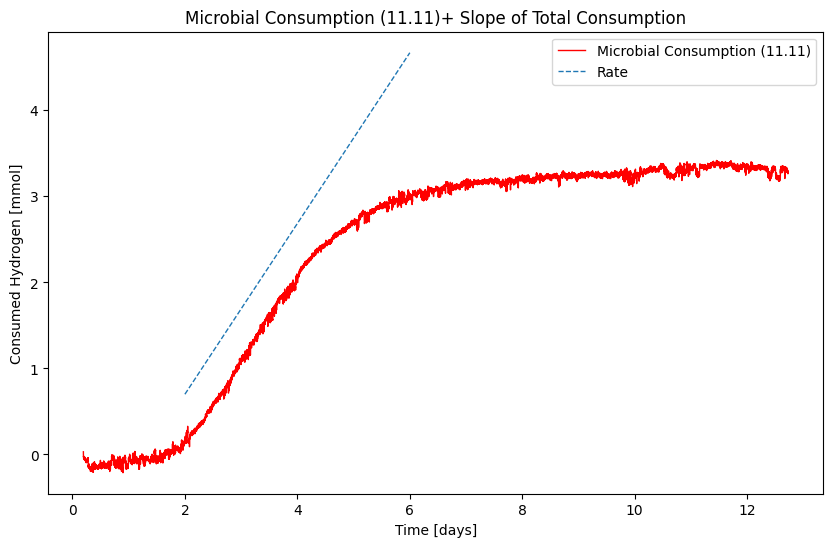

In [172]:
plt.figure(figsize=(10,6))
plt.plot(time_days_trimmed, moles_consumed, label="Microbial Consumption (11.11)", linewidth=1, color="red")
#plt.plot(th_cum_min_2,th_c_vol2_3, label="Microbial Consumption (01.07)", linewidth=1, color="blue")

m = 1.1243       # slope
x_start = 2
y_start = 0.7    # starting y-value

# Create x-values for the line (same range as your plot)
x_line = np.linspace(x_start, 6, 100)
y_line = slope * (x_line - x_start) + y_start

plt.plot(x_line, y_line, label="Rate", linestyle="--", linewidth=1)
plt.xlabel("Time [days]")
plt.ylabel("Consumed Hydrogen [mmol]")
plt.legend()
plt.title("Microbial Consumption (11.11)+ Slope of Total Consumption")
plt.show()

In [ ]:
ro=4.523 #kg/m^3
v=20 #ml
m=v*ro 
M=2.016 #g/mol

n=(m/M) #mmol

print(n)
print(2.94/67.5)


44.87103174603174
0.043555555555555556


In [44]:
import numpy as np

def find_first_above_threshold(arr, threshold=0.45):
    """
    Returns the index of the first element in an array greater than the threshold.
    Returns None if no such value exists.
    """
    # Create a boolean mask where values > threshold
    mask = arr > threshold
    
    # Check if any value actually meets the criteria
    if not np.any(mask):
        return None
    
    # argmax returns the index of the first 'True' (1) in a boolean array
    return np.argmax(mask)

# Example usage:
data = np.array([0.1, 0.3, 0.44, 0.52, 0.48])
index = find_first_above_threshold(v1B)

print(f"Location: {index}") # Output: 3
print(f"Value: {v1B[index]}") # Output: 0.52

Location: 9980
Value: 0.48955
